In [1]:
## lets import necessary packages
## conda env compare_PSD
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import scipy.stats as stats
from statistics import mean


In [2]:
full_df_NO = pd.read_pickle("full_df_2021_NOX.pkl")

## This the data cleaning. Keeping only the relevant features and removing the less than equal to zero target values
cols=[i for i in range(2,28) ]
cols.append(0)

df1= full_df_NO.drop(full_df_NO.columns[cols], axis=1)
df2 = df1.drop(df1.columns[[2,3,4,5,6,9]], axis=1) 
j=[]

for i in range(4,72):
    j.append(i)
df3 = df2.drop(df2.columns[j], axis=1) 
df4 = df3.drop(df3.columns[[11,12,13,14,15,16,17,18]], axis=1) 
df4 = df4.drop(df3.columns[[6]], axis=1) 
df4.rename(columns={'NO': 'NO (ppb)','pda': 'Average Pupil Diameter (mm)', 'pup_dis': 'Pupil Distance (mm)',
                    'pd_diff': 'Difference in Pupil Diameter (mm)', 'ECG.': 'ECG (V)',
                    'Resp.': 'Respiration Rate (brpm)',
                    'Temp.': r'Skin Temperature ($\mathrm{^o C})$','HR': 'Heart Rate (bpm)',
                    'SpO2':r'$\mathrm{SpO_2}$ (%)',
                    'GSR':r'GSR ($\mathrm{\mu S}$)'}, inplace=True)

df_final = df4[df4['NO (ppb)'] >0]

## Lets change some of variables to standard units

pd.options.mode.chained_assignment = None ## apparently this needs to be added to overcome an error i dont understand  

df_final[r'$\mathrm{SpO_2}$ (%)']=df_final[r'$\mathrm{SpO_2}$ (%)']*1000000 ## change the SpO2 to percentage
df_final[r'GSR ($\mathrm{\mu S}$)']=df_final[r'GSR ($\mathrm{\mu S}$)']*1000 ## convert kiloohms to ohms
df_final[r'GSR ($\mathrm{\mu S}$)']=1/df_final[r'GSR ($\mathrm{\mu S}$)']  ## convert ohms to siemans by taking the reciprocal
df_final[r'GSR ($\mathrm{\mu S}$)']=df_final[r'GSR ($\mathrm{\mu S}$)']*1000000 ## convert siemens to microsiemens
df_final

j=[]

for i in range(10,330):
    j.append(i)
df_final = df_final.drop(df_final.columns[j], axis=1) 
df_final

,NO (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$
dateTime,,,,,,,,,,
2021-05-26 11:52:14.898927,0.1,3.235,66.06,-0.01,-0.001403,41.631553,99.0,118.0,0.078621,29.5625
2021-05-26 11:52:19.881416,0.8,3.060,65.49,0.06,-0.001208,40.439460,99.0,116.0,0.079237,29.5625
2021-05-26 11:52:24.902444,1.4,3.060,65.52,0.24,-0.001088,40.072661,100.0,116.0,0.079105,29.5000
2021-05-26 11:52:29.892316,2.1,3.170,65.75,0.14,-0.000844,38.880568,99.0,118.0,0.079083,29.5000
2021-05-26 11:52:39.897584,3.6,3.175,65.54,0.15,-0.000421,38.192824,97.0,122.0,0.078884,29.4375
...,...,...,...,...,...,...,...,...,...,...
2021-06-10 11:26:26.068698,35.7,2.750,65.90,0.02,-0.001450,28.931178,97.0,120.0,0.091122,29.3750
2021-06-10 11:26:31.056772,43.9,2.595,65.29,0.11,-0.001048,29.297976,96.0,120.0,0.091181,29.3750
2021-06-10 11:26:41.060407,6.8,2.615,66.04,0.05,-0.001223,27.463986,96.0,122.0,0.091682,29.4375


In [3]:
## lets load the old PSD dataframe

old_psd=pd.read_pickle('../WM_PSD/Entire_PSD_WM.pkl')
old_psd

,Fp1-delta (W/Hz),Fp2-delta (W/Hz),F3-delta (W/Hz),F4-delta (W/Hz),C3-delta (W/Hz),C4-delta (W/Hz),P3-delta (W/Hz),P4-delta (W/Hz),O1-delta (W/Hz),O2-delta (W/Hz),...,FT7-gamma (W/Hz),FT8-gamma (W/Hz),TP7-gamma (W/Hz),TP8-gamma (W/Hz),PO7-gamma (W/Hz),PO8-gamma (W/Hz),Fpz-gamma (W/Hz),CPz-gamma (W/Hz),POz-gamma (W/Hz),TP10-gamma (W/Hz)
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-05-26 11:45:55.000000000,9.455450e-10,8.221925e-10,1.161968e-10,1.004097e-11,1.478660e-11,1.671486e-09,1.393506e-09,1.765678e-10,2.603560e-11,3.729719e-11,...,8.296102e-11,5.047358e-11,7.908187e-12,4.430761e-12,3.293709e-12,1.535328e-10,1.132436e-10,2.599736e-11,1.515054e-11,2.423078e-11
2021-05-26 11:45:56.000001853,1.910614e-09,1.207838e-09,8.727718e-11,6.856339e-12,7.440724e-12,2.942805e-09,1.784802e-09,1.163309e-10,3.104509e-11,5.338824e-11,...,1.819236e-10,8.126887e-11,1.483633e-11,3.254162e-12,4.838564e-12,3.046496e-10,1.325344e-10,1.300425e-11,1.189858e-11,4.012207e-11
2021-05-26 11:45:57.000003707,2.425002e-09,1.145655e-09,8.870916e-11,6.892333e-12,5.345311e-12,4.249434e-09,1.940478e-09,1.207903e-10,3.998133e-11,4.452014e-11,...,2.045204e-10,1.077955e-10,1.120932e-11,4.037847e-12,3.730691e-12,3.289403e-10,1.441325e-10,2.426423e-11,1.347574e-11,2.281527e-11
2021-05-26 11:45:58.000005560,1.186406e-11,6.496439e-12,2.671286e-12,5.341584e-12,7.891438e-12,1.087499e-11,8.097877e-12,3.049897e-12,2.348145e-11,2.526158e-11,...,6.555742e-12,5.412952e-12,3.480415e-12,3.860529e-12,3.188954e-12,1.503249e-11,1.163322e-11,5.564777e-12,1.633082e-11,4.461403e-11
2021-05-26 11:45:59.000007414,1.968229e-11,7.796614e-12,6.295897e-12,4.245387e-12,6.839395e-12,1.338696e-11,6.901717e-12,9.502428e-12,1.819646e-11,3.815634e-11,...,4.197687e-12,5.170844e-12,1.678015e-12,4.386478e-12,3.445592e-12,3.854843e-12,6.889539e-12,5.215879e-12,1.636216e-11,3.159716e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 11:27:09.001969242,5.483634e-10,1.964949e-10,9.796263e-12,3.854609e-12,4.206024e-12,1.075532e-09,4.515000e-10,2.144972e-11,5.529533e-12,4.774922e-12,...,6.670757e-11,2.242754e-11,7.328381e-12,3.542897e-12,6.403714e-12,2.296957e-10,3.618208e-11,2.136937e-11,1.920977e-11,2.399002e-11
2021-06-10 11:27:10.001975396,3.916743e-10,1.882370e-10,1.036563e-11,7.650841e-12,4.482464e-12,7.757659e-10,3.033866e-10,1.139618e-11,7.201484e-12,1.272077e-11,...,5.131737e-11,2.569928e-11,3.062611e-12,5.872509e-12,5.145291e-12,1.269998e-10,3.907463e-11,1.274181e-11,3.126643e-11,3.949292e-11
2021-06-10 11:27:11.001981550,1.254662e-09,3.864981e-10,1.066976e-11,6.856089e-12,9.659101e-12,2.094044e-09,5.774310e-10,1.277193e-11,1.135055e-11,1.531118e-11,...,2.247303e-10,5.572766e-11,6.114959e-12,5.723531e-12,5.872219e-12,1.075920e-09,2.419923e-10,4.817366e-11,2.689392e-11,5.941404e-11


In [4]:
## lets merge it

tol_2 = pd.Timedelta('1s')
full_df = pd.merge_asof(left=df_final, right=old_psd, right_index=True, left_index=True, 
                                                    direction='nearest', tolerance=tol_2)
df_final=full_df
df_final

,NO (ppb),Average Pupil Diameter (mm),Pupil Distance (mm),Difference in Pupil Diameter (mm),ECG (V),Respiration Rate (brpm),$\mathrm{SpO_2}$ (%),Heart Rate (bpm),GSR ($\mathrm{\mu S}$),Skin Temperature ($\mathrm{^o C})$,...,FT7-gamma (W/Hz),FT8-gamma (W/Hz),TP7-gamma (W/Hz),TP8-gamma (W/Hz),PO7-gamma (W/Hz),PO8-gamma (W/Hz),Fpz-gamma (W/Hz),CPz-gamma (W/Hz),POz-gamma (W/Hz),TP10-gamma (W/Hz)
dateTime,,,,,,,,,,,,,,,,,,,,,
2021-05-26 11:52:14.898927,0.1,3.235,66.06,-0.01,-0.001403,41.631553,99.0,118.0,0.078621,29.5625,...,5.685509e-11,3.444179e-11,5.473620e-12,3.099440e-11,7.072506e-11,4.222885e-10,1.406172e-10,2.106899e-11,6.619135e-11,2.730519e-10
2021-05-26 11:52:19.881416,0.8,3.060,65.49,0.06,-0.001208,40.439460,99.0,116.0,0.079237,29.5625,...,6.097312e-11,2.370012e-11,9.296302e-12,9.478712e-12,5.806335e-12,6.422788e-11,5.142535e-11,3.752179e-11,3.517177e-11,6.657332e-11
2021-05-26 11:52:24.902444,1.4,3.060,65.52,0.24,-0.001088,40.072661,100.0,116.0,0.079105,29.5000,...,5.919716e-11,1.693891e-11,3.745555e-12,3.817670e-12,5.293440e-12,1.242198e-10,4.722632e-11,9.493504e-12,1.209926e-11,6.117785e-11
2021-05-26 11:52:29.892316,2.1,3.170,65.75,0.14,-0.000844,38.880568,99.0,118.0,0.079083,29.5000,...,2.740151e-12,2.470341e-12,1.820037e-12,5.838580e-12,4.239627e-12,1.952046e-09,4.445544e-10,8.643584e-11,6.126765e-11,5.439174e-11
2021-05-26 11:52:39.897584,3.6,3.175,65.54,0.15,-0.000421,38.192824,97.0,122.0,0.078884,29.4375,...,9.402215e-11,5.576382e-11,5.351877e-12,2.382751e-12,4.847664e-12,2.715795e-10,1.534969e-10,2.448647e-11,1.399371e-11,4.798162e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-10 11:26:26.068698,35.7,2.750,65.90,0.02,-0.001450,28.931178,97.0,120.0,0.091122,29.3750,...,3.361201e-11,1.487056e-11,8.240179e-12,4.508442e-12,4.596400e-12,4.808129e-11,8.758995e-12,8.020757e-12,3.769337e-11,6.244207e-11
2021-06-10 11:26:31.056772,43.9,2.595,65.29,0.11,-0.001048,29.297976,96.0,120.0,0.091181,29.3750,...,4.050003e-11,2.318455e-11,1.241688e-11,1.085344e-11,1.076027e-11,5.950234e-10,2.702698e-10,5.346029e-11,5.263959e-11,1.230118e-10
2021-06-10 11:26:41.060407,6.8,2.615,66.04,0.05,-0.001223,27.463986,96.0,122.0,0.091682,29.4375,...,1.345098e-10,2.547696e-11,3.618754e-12,1.092415e-11,1.444973e-11,9.713720e-10,3.226369e-10,8.662263e-11,4.259228e-11,1.292154e-10


In [5]:
## Lets create a Train-Test set and transform the data.

features=df_final.drop("NO (ppb)",axis=1)
target=df_final["NO (ppb)"].copy()

#from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)

In [6]:
## lets optimize the hyperparameters

param_grid=[{'n_estimators':[80,90,100,110,120], 'max_features':[250, 275, 300, 325]},]

In [7]:
## Lets now train the model using Random Forest Regressor 

forest_reg=RandomForestRegressor(n_jobs=-1)
grid_search=GridSearchCV(forest_reg,param_grid,cv=3,scoring="neg_mean_squared_error",return_train_score=True)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid=[{'max_features': [250, 275, 300, 325],
                          'n_estimators': [80, 90, 100, 110, 120]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_features=275, n_estimators=80, n_jobs=-1)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## Lets now train the model using Random Forest Regressor 

final_model.fit(X_train,y_train)

## The train prediction
train_prediction_RF=final_model.predict(X_train)
RF_mse=mean_squared_error(y_train,train_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_train=RF_rmse

print('The train RMSE for NO is:::', '%.2f' % RF_rmse_train)

The train RMSE for NO is::: 4.80


In [11]:
## The test prediction

test_prediction_RF=final_model.predict(X_test)
RF_mse=mean_squared_error(y_test,test_prediction_RF)
RF_rmse=np.sqrt(RF_mse)
RF_rmse_test=RF_rmse

print('The test RMSE for NO is:::', '%.2f' % RF_rmse_test)

The test RMSE for NO is::: 10.82


In [12]:
### The correlation values

#from scipy.stats import pearsonr

## The train correlation
train_r_sq=pearsonr(y_train,train_prediction_RF)[0]
correlation_train=int(train_r_sq*100)/100 ## display only two digits without rounding
print(correlation_train)

## The test correlation
test_r_sq=pearsonr(y_test,test_prediction_RF)[0]
correlation_test=int(test_r_sq*100)/100 ## display only two digits without rounding
print(correlation_test)

0.96
0.69


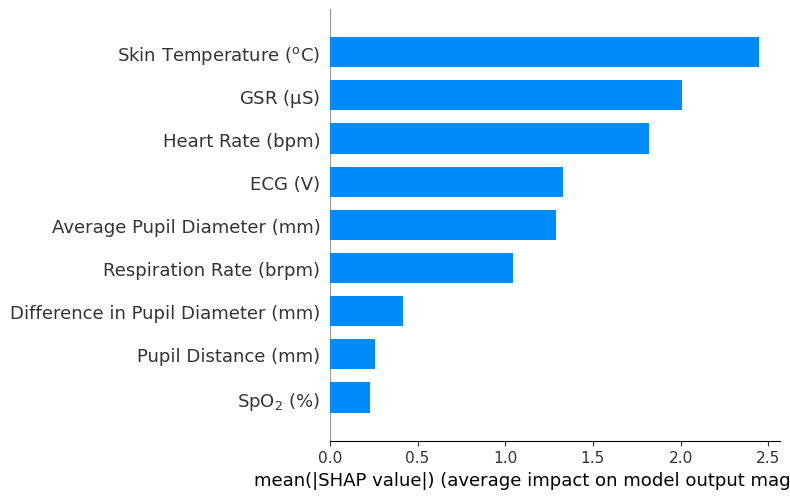

In [13]:
## displaying the feature importance using shap values

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=9)

In [14]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction_RF, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction_RF, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])
sns_df

,Actual,Estimated,Label
0,1.9,3.88125,Train
1,12.6,13.44875,Train
2,2.8,4.59750,Train
3,63.9,50.30875,Train
4,2.6,4.27000,Train
...,...,...,...
77,3.7,7.17125,Test
78,11.7,12.67125,Test
79,5.7,6.76500,Test
80,6.5,6.15500,Test


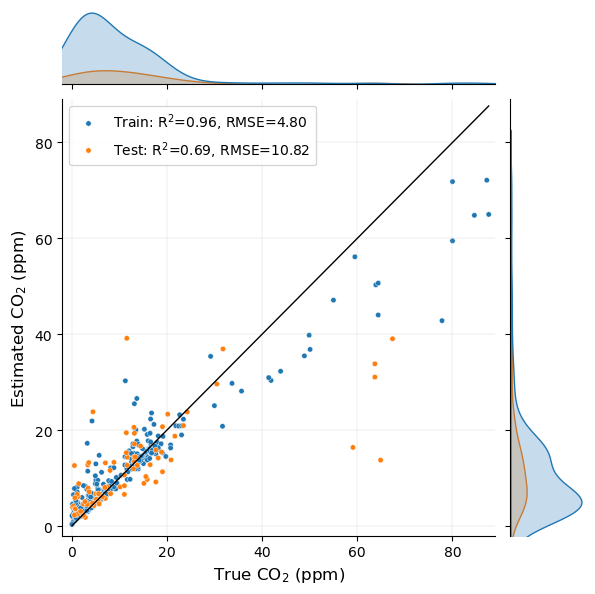

In [15]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',
                  xlim=[-2, 89], ylim=[-2, 89],s=15)
plt.grid(axis='both',linewidth=0.15)


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1)

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()


g.ax_joint.legend(handles=handles, labels=[ f'Train: R$^2$={correlation_train}, RMSE={RF_rmse_train:.2f}', 
                                               f'Test: R$^2$={correlation_test}, RMSE={RF_rmse_test:.2f}'], title=None)


g.set_axis_labels(r'True $\mathrm{CO_2}$ (ppm)', r'Estimated $\mathrm{CO_2}$ (ppm)',fontsize=12)
plt.show()

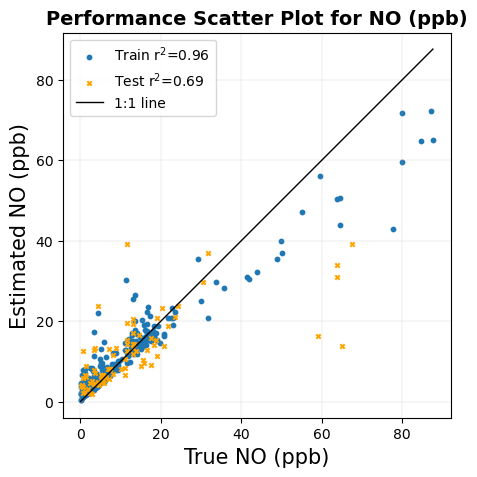

In [16]:
## Optional

import matplotlib as mpl
mpl.rcParams['mathtext.default']='regular'

plt.figure(figsize=(5,5))
plt.scatter(y_train, train_prediction_RF,s=10,c='C0',label='Train $r^2$={}'.format(correlation_train))
plt.scatter(y_test, test_prediction_RF,marker='x',s=10,c='orange',label='Test $r^2$={}'.format(correlation_test))


p1 = max(max(train_prediction_RF), max(y_train))
p2 = min(min(train_prediction_RF), min(y_train))
plt.plot([p1, p2], [p1, p2], 'black',label='1:1 line',linewidth=1)
plt.xlabel('True NO (ppb)', fontsize=15)
plt.ylabel('Estimated NO (ppb)', fontsize=15)
plt.axis('equal')
plt.title("Performance Scatter Plot for NO (ppb)", fontsize=14,fontweight="bold")
plt.legend()
plt.grid(axis='both',linewidth=0.15)
plt.show()

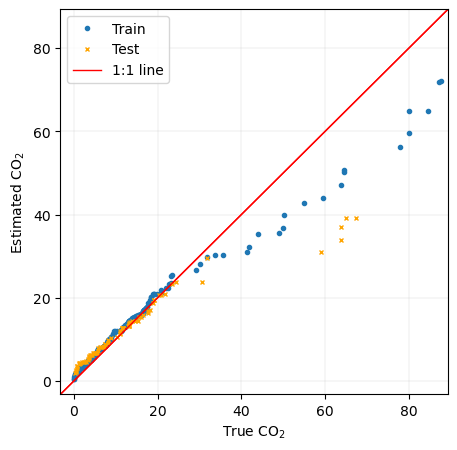

In [17]:
## Lets plot the quantile quantile 

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction_RF, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train')
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction_RF, fit=False)

qqq = pp_yy.qqplot(xlabel=r'True $\mathrm{CO_2}$',ylabel=r'Estimated $\mathrm{CO_2}$',
                    marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange', markerfacecolor = 'orange', label='Test')
sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

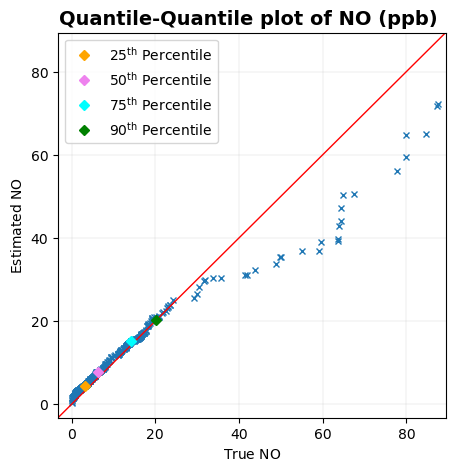

In [18]:
## optinal. QQ plot of the entire distribution

import statsmodels.api as sm
import scipy.stats as stats

all_preds_NO=np.concatenate((train_prediction_RF,test_prediction_RF)) ## the list of all predictions and target values

preds=np.sort(all_preds_NO)
tars=target.sort_values()

plt.rc("figure", figsize=(5,5)) ## to make same figure size in statsmodels.api

pp_x = sm.ProbPlot(preds, fit=False)
pp_y = sm.ProbPlot(tars, fit=False)
qq = pp_x.qqplot(xlabel=r'True $\mathrm{NO}$',ylabel=r'Estimated $\mathrm{NO}$',marker='x',markersize=4,other=pp_y)

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1)
tars_25=np.percentile(tars,25)  ## for the percentiles                                                        
tars_50=np.percentile(tars,50)
tars_75=np.percentile(tars,75)
tars_90=np.percentile(tars,90)


preds_25=np.percentile(preds,25)
preds_50=np.percentile(preds,50)
preds_75=np.percentile(preds,75)  
preds_90=np.percentile(tars,90)  ## end of percentiles

plt.plot(tars_25,preds_25,marker="D",markersize=5,color="orange",linestyle ='None',label=r"$\mathrm{25^{th}}$ Percentile")
plt.plot(tars_50,preds_50,marker="D",markersize=5,color="violet",linestyle ='None',label=r"$\mathrm{50^{th}}$ Percentile")
plt.plot(tars_75,preds_75,marker="D",markersize=5,color="Cyan",linestyle ='None',label=r"$\mathrm{75^{th}}$ Percentile")
plt.plot(tars_90,preds_90,marker="D",markersize=5,color="Green",linestyle ='None',label=r"$\mathrm{90^{th}}$ Percentile")


plt.grid(axis='both',linewidth=0.15)

plt. title('Quantile-Quantile plot of NO (ppb) ',fontsize=14,fontweight="bold")

plt.legend()
plt.show()

In [19]:
## lets calculate the average values RMSE

j_train=[]
j_test=[]
k_train=[]
k_test=[]
for i in range(0,50):
    
    X_train,X_test,y_train,y_test=train_test_split(features, target, test_size=0.20)
    final_model.fit(X_train,y_train)

    train_prediction=final_model.predict(X_train)
    mse_train=mean_squared_error(y_train,train_prediction)
    rmse_train=np.sqrt(mse_train)
    j_train.append(rmse_train)
    
    test_prediction=final_model.predict(X_test)

    mse_test=mean_squared_error(y_test,test_prediction)
    rmse_test=np.sqrt(mse_test)
    j_test.append(rmse_test)

## lets calculate the average correlation    
  
    train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
    correlation_train=int(train_r_sq*100)/100 ## display 
    k_train.append(correlation_train)
    
    test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
    correlation_test=int(test_r_sq*100)/100
    k_test.append(correlation_test)

average_train_rmse=mean(j_train)
average_test_rmse=mean(j_test)
    
average_train_rsq=mean(k_train)
average_test_rsq=mean(k_test)

print('The average train RMSE for NO is:::', '%.2f' % average_train_rmse)
print('The average test RMSE for NO is:::', '%.2f' % average_test_rmse)

print('The average train r square for NO is:::', '%.2f' % average_train_rsq)
print('The average test r square for NO is:::', '%.2f' % average_test_rsq)

The average train RMSE for NO is::: 4.55
The average test RMSE for NO is::: 11.50
The average train r square for NO is::: 0.93
The average test r square for NO is::: 0.36


In [20]:
print('The test RMSE error in each of the trail is:::', j_test)

The test RMSE error in each of the trail is::: [8.591121146693522, 14.294184384629949, 12.320120073759824, 9.235977353138264, 7.789958589163625, 14.32857809713941, 11.325969845034919, 12.161584674967424, 11.756927246574678, 10.092264972311291, 9.744962455267498, 9.040023079770007, 9.91514048717089, 11.492090716149141, 8.788619693045884, 8.804353905560577, 13.93223352799206, 8.870065784198337, 10.83252227918853, 12.713273531068314, 11.186136489500644, 12.24927457642403, 11.199080476769172, 13.53563167241712, 12.21410467573148, 13.06010147704455, 9.331417895831606, 12.394643863133078, 11.669270846475998, 13.015832849407664, 12.654661408130238, 13.111512275628753, 15.388470832592457, 12.316138260125637, 8.830784648468217, 9.92612604005761, 9.321782652564169, 12.625196998734705, 9.519874652303953, 13.664120986170138, 13.587845748905032, 13.064655231232688, 10.527815992196517, 13.78576916874546, 11.967799923286277, 8.650942529583261, 12.9214090210758, 13.53687045723326, 10.451484901320507, 

In [21]:
test_rmse=pd.DataFrame(j_test, columns=['Test RMSE Error for NO (ppb)'])
test_rmse.head()

,Test RMSE Error for NO (ppb)
0,8.591121
1,14.294184
2,12.320120
3,9.235977
4,7.789959


In [22]:
print('The r^2 in each of the trail in test set is:::', k_test)

The r^2 in each of the trail in test set is::: [0.37, 0.14, 0.3, 0.22, 0.33, 0.32, 0.29, 0.42, 0.47, 0.34, 0.19, 0.44, 0.7, 0.24, 0.34, 0.59, 0.17, 0.36, 0.33, 0.2, 0.38, 0.35, 0.28, 0.29, 0.34, 0.42, 0.63, 0.29, 0.45, 0.45, 0.47, 0.33, 0.46, 0.43, 0.6, 0.53, 0.19, 0.22, 0.54, 0.41, 0.15, 0.42, 0.19, 0.23, 0.32, 0.47, 0.52, 0.3, 0.35, 0.26]


In [23]:
test_r2=pd.DataFrame(k_test, columns=['Test R$^2$ for NO (ppb)'])
test_r2.head()

,Test R$^2$ for NO (ppb)
0,0.37
1,0.14
2,0.30
3,0.22
4,0.33


In [24]:
combined_NO_WM=pd.concat([test_rmse,test_r2], axis=1)
combined_NO_WM

,Test RMSE Error for NO (ppb),Test R$^2$ for NO (ppb)
0,8.591121,0.37
1,14.294184,0.14
2,12.320120,0.30
3,9.235977,0.22
4,7.789959,0.33
5,14.328578,0.32
6,11.325970,0.29
7,12.161585,0.42
8,11.756927,0.47
9,10.092265,0.34
